# About

The goal of theis project is to build a thoughtful, end-to-end prototype that detects breast cancer tumor from gigapixel pathology images - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data.

Considerations for the project:
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of the prediction results (both heatmaps showing predictions on individual slides, and other metrics/diagrams to communicate how well the model performs).

<img src="./cancer_metastases_prediction.png" alt="Cancer metastases prediction" />

<img src="./cancer_metastases.png" alt="Actual cancer metastases" />

# Data Preprocessing


This Google Drive [folder](https://drive.google.com/drive/folders/11GEhOPP0T4Oaw_Yhb4jD_fh79DNXq8no?usp=sharing) contains breast cancer medical imaging slides used in this project.

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os, glob
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import pandas as pd
from keras.models import load_model
from keras import models, layers, optimizers
from tensorflow.keras.layers import Dropout
import time

In [320]:
import pathlib

DATA_DIR = 'D:/medical_imaging_data/data/'
WINDOWS_DIR = 'D:/medical_imaging_data/patches_3/'
MASKS_DIR = 'D:/medical_imaging_data/masks_3/'

file_list = os.listdir(DATA_DIR)
filenames_slides, filenames_masks = [], []

for file in file_list:
    if pathlib.Path(DATA_DIR + file).suffix == '.tif':
        if os.path.splitext(file)[0][-4:] == 'mask':
            filenames_masks.append(file)
        else:
            filenames_slides.append(file)

test_slides, test_masks = filenames_slides[-2:], filenames_masks[-2:]
filenames_masks = filenames_masks[:9]
filenames_slides = filenames_slides[:9]

- Use total of 9 slides with multiple zoom levels for training

In [217]:
# training slides
filenames_slides

['tumor_002.tif',
 'tumor_005.tif',
 'tumor_012.tif',
 'tumor_016.tif',
 'tumor_019.tif',
 'tumor_023.tif',
 'tumor_031.tif',
 'tumor_035.tif',
 'tumor_057.tif']

In [18]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [19]:
# imporve efficiency by ignoring non-tissue areas of the slide and looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

- Test reading slide and mask at zoom level 5

In [224]:
example_idx = -1
example_slide, example_mask = open_slide(DATA_DIR + test_slides[example_idx]), open_slide(DATA_DIR + test_masks[example_idx]) 

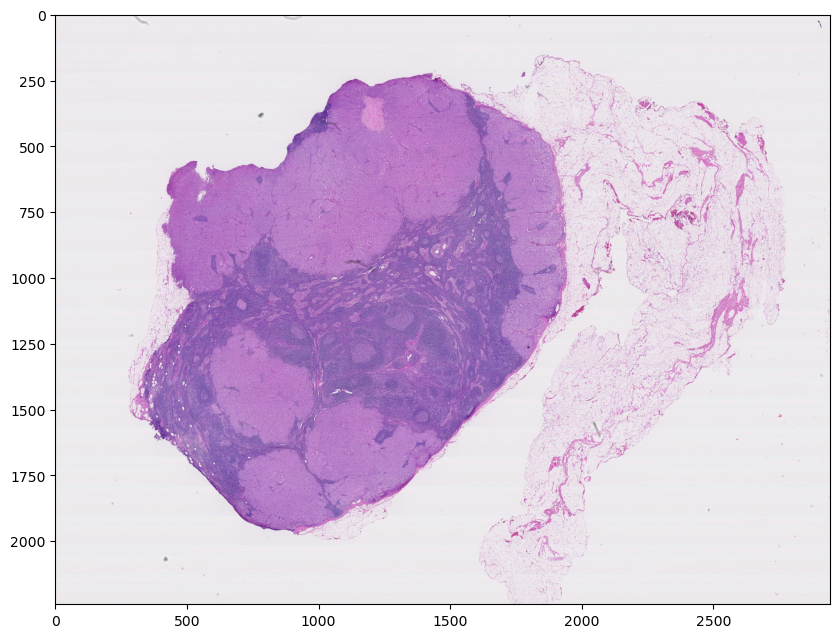

In [222]:
slide_image = read_slide(example_slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=example_slide.level_dimensions[5][0], 
                         height=example_slide.level_dimensions[5][1])
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)


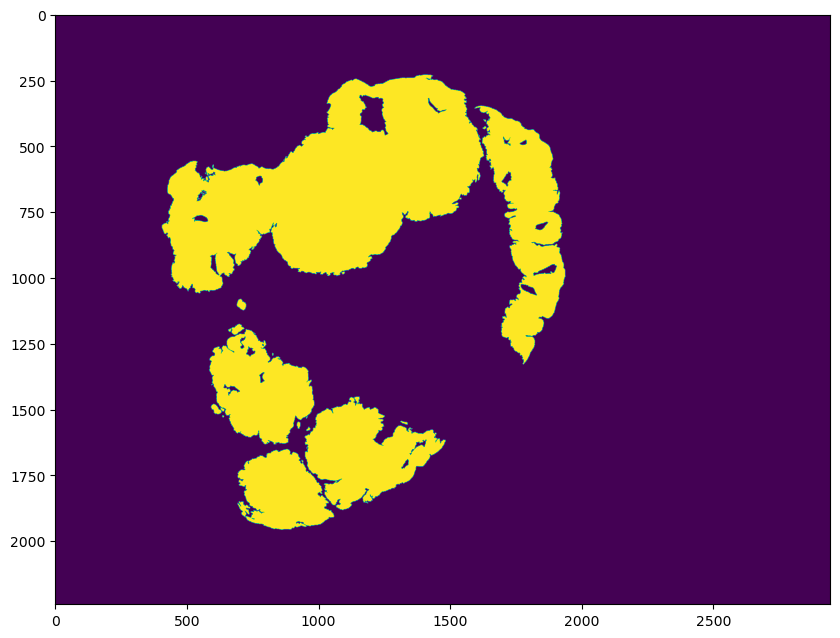

In [225]:

mask_image = read_slide(example_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=example_mask.level_dimensions[5][0], 
                        height=example_mask.level_dimensions[5][1])[:,:,0]


plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)


- Overlay the mask on the slide image to see where the cancer is located, red regions contain cancer

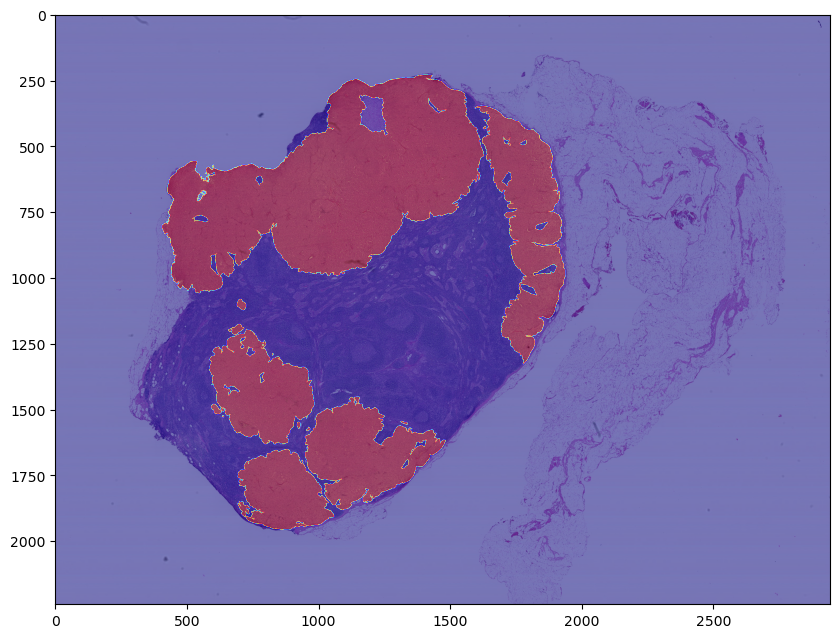

In [227]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.


- This is an example patch of the slide and mask that contains cancer pixels

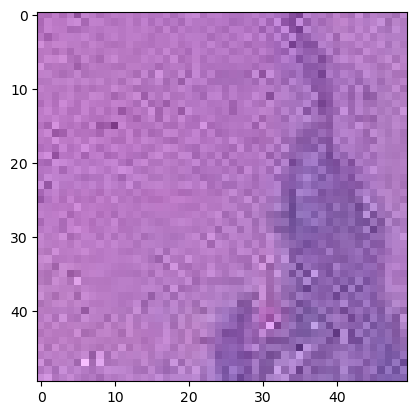

In [229]:
example_patch = read_slide(example_slide, x=370 * 128, y=120 * 128, level=7, width=50, height=50)
plt.imshow(example_patch)

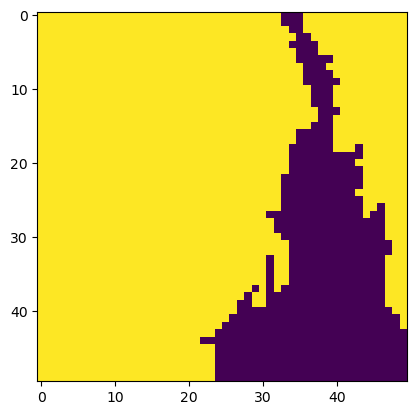

In [230]:
example_region = read_slide(example_mask, x=370 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(example_region)

- This help calculate tissue pixel percentage so we can ignore patches that doesn't contain tissue.

2129295 tissue_pixels pixels (42.4 percent of the image)


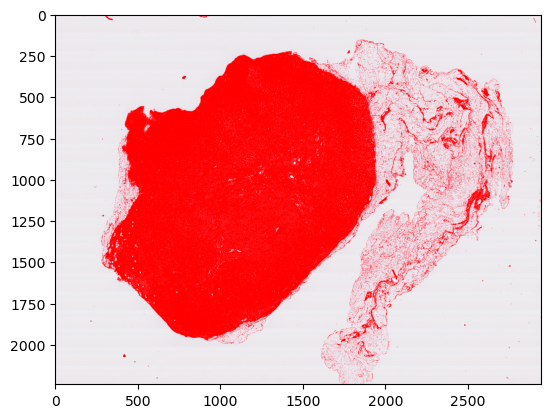

In [232]:
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)
# red areas are tissue regions

## Generate Training Data
- Slide window size of 100x100 across slides at zoom levels of 5, 4, 3, and 2 to generate training patches 

In [27]:
# Generate a list of patches that we'll use to train our model
def generate_windows(slide_name, mask_name, level, window_size, stride):
    patch_images, labels = [], []
    patch, mask = open_slide(DATA_DIR + slide_name), open_slide(DATA_DIR + mask_name)
    for i in range(0, patch.level_dimensions[level][0] - window_size + 1, stride):
        for j in range(0, patch.level_dimensions[level][1] - window_size + 1, stride):
            # downsampling
            downsample_factor = int(patch.level_downsamples[level])
            x, y = i * downsample_factor, j * downsample_factor
            window_image = read_slide(patch, 
                                        x=x, 
                                        y=y, 
                                        level=level, 
                                        width=window_size, 
                                        height=window_size)
            mask_image = read_slide(mask, 
                                    x=x, 
                                    y=y, 
                                    level=level, 
                                    width=window_size, 
                                    height=window_size)

            percent_tissue = len(find_tissue_pixels(window_image)) / float(window_size * window_size) * 100
            # label = 0 if no cancer, 1 if cancer
            label = np.amax(mask_image[:,:,0])
            # Only keep patches that contain tissue
            if percent_tissue > 90:
                # Save the patch image on disk 
                outfile = slide_name[:-4] + '_level' + str(level) + '_x' + str(x) + '_y' + str(y) + '_label' + str(label)
                patch_images.append(WINDOWS_DIR + outfile + '.jpg')
                window_image = image.array_to_img(window_image, data_format='channels_last')
                image.save_img((WINDOWS_DIR + outfile + '.jpg'), window_image, file_format='jpeg')
                labels.append(label)

    return patch_images, labels


In [28]:
# remove all files in the windows and masks directories
for f in os.scandir(WINDOWS_DIR):
    os.remove(f.path)
for f in os.scandir(MASKS_DIR):
    os.remove(f.path)

In [29]:
patches, labels = [], []

In [30]:
WINDOW_SIZE = 100
STRIDE = 100
def generate_patches(level):
    for i in range(len(filenames_slides)):
        print("Processing slide %d" % i)
        slide, mask = filenames_slides[i], filenames_masks[i] 
        p, l = generate_windows(slide, mask, level, WINDOW_SIZE, STRIDE)
        print("Generated %d windows" % len(p))
        patches.extend(p)
        labels.extend(l)
    print("Level:", level)
    print ("Generated total of %d windows" % len(patches))


In [31]:
# zoom level 5
generate_patches(5)

Processing slide 0
Generated 28 windows
Processing slide 1
Generated 32 windows
Processing slide 2
Generated 80 windows
Processing slide 3
Generated 53 windows
Processing slide 4
Generated 11 windows
Processing slide 5
Generated 33 windows
Processing slide 6
Generated 29 windows
Processing slide 7
Generated 28 windows
Processing slide 8
Generated 14 windows
Level: 5
Generated total of 308 windows


In [32]:
# Zoom level 4
generate_patches(4)

Processing slide 0
Generated 71 windows
Processing slide 1
Generated 155 windows
Processing slide 2
Generated 312 windows
Processing slide 3
Generated 199 windows
Processing slide 4
Generated 11 windows
Processing slide 5
Generated 178 windows
Processing slide 6
Generated 120 windows
Processing slide 7
Generated 140 windows
Processing slide 8
Generated 69 windows
Level: 4
Generated total of 1563 windows


In [33]:
# Zoom level 3
generate_patches(3)

Processing slide 0
Generated 122 windows
Processing slide 1
Generated 549 windows
Processing slide 2
Generated 987 windows
Processing slide 3
Generated 676 windows
Processing slide 4
Generated 2 windows
Processing slide 5
Generated 787 windows
Processing slide 6
Generated 466 windows
Processing slide 7
Generated 642 windows
Processing slide 8
Generated 201 windows
Level: 3
Generated total of 5995 windows


In [34]:
# Zoom level 2
generate_patches(2)

Processing slide 0
Generated 400 windows
Processing slide 1
Generated 2265 windows
Processing slide 2
Generated 3864 windows
Processing slide 3
Generated 2729 windows
Processing slide 4
Generated 58 windows
Processing slide 5
Generated 3308 windows
Processing slide 6
Generated 1779 windows
Processing slide 7
Generated 2731 windows
Processing slide 8
Generated 850 windows
Level: 2
Generated total of 23979 windows


In [35]:
patches = np.array(patches)
labels = np.array(labels)

In [36]:
print(patches.shape)
print(labels.shape)

(23979,)
(23979,)


In [37]:
patches

array(['D:/medical_imaging_data/patches_3/tumor_002_level5_x19200_y105600_label0.jpg',
       'D:/medical_imaging_data/patches_3/tumor_002_level5_x19200_y108800_label0.jpg',
       'D:/medical_imaging_data/patches_3/tumor_002_level5_x22400_y102400_label0.jpg',
       ...,
       'D:/medical_imaging_data/patches_3/tumor_057_level2_x77600_y219200_label0.jpg',
       'D:/medical_imaging_data/patches_3/tumor_057_level2_x78800_y10800_label0.jpg',
       'D:/medical_imaging_data/patches_3/tumor_057_level2_x82400_y132000_label0.jpg'],
      dtype='<U76')

In [38]:
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [39]:
import pandas as pd

data = pd.DataFrame({'patch': patches, 'label': labels})

In [138]:
data

patch  label
0      D:/medical_imaging_data/patches_3/tumor_002_le...      0
1      D:/medical_imaging_data/patches_3/tumor_002_le...      0
2      D:/medical_imaging_data/patches_3/tumor_002_le...      0
3      D:/medical_imaging_data/patches_3/tumor_002_le...      0
4      D:/medical_imaging_data/patches_3/tumor_002_le...      0
...                                                  ...    ...
23974  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23975  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23976  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23977  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23978  D:/medical_imaging_data/patches_3/tumor_057_le...      0

[23979 rows x 2 columns]

In [41]:
# save df
data.to_pickle('data.pkl')

## Balance Dataset

I did not end up balancing the dataset because in most slides the amount of positive patches (contains cancer pixels) and the amount of negative patches (does not contain cancer) are not balanced.
Balanced dataset produced worse accuracy

In [80]:
# data = pd.read_pickle('data.pkl')

In [90]:
# balance_count = data.groupby(data['label'].apply(lambda x: 'negative' if x == 0 else 'positive'))['label'].count()
# balance_count

label
negative    21909
positive     2070
Name: label, dtype: int64

In [91]:
# from sklearn.utils import shuffle
# import random
# N = min(balance_count.positive, balance_count.negative)
# df = data.sample(frac=1).reset_index(drop=True)

# df_positive = df[df.label == 1].sample(n=N, random_state=42)
# df_negative = df[df.label == 0].sample(n=N, random_state=42)

# df_balanced = pd.concat([df_positive, df_negative])
# df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [ ]:
# df_balanced.groupby(df_balanced['label'].apply(lambda x: 'negative' if x == 0 else 'positive'))['label'].count()

In [94]:
# df_balanced.to_pickle('data_balanced.pkl')

## Create Train/test Split

In [4]:
WINDOW_SIZE = 100
STRIDE = 100

In [97]:
# df_balanced = pd.read_pickle('data_balanced.pkl')

In [85]:
df = pd.read_pickle('data.pkl')

In [86]:
df

patch  label
0      D:/medical_imaging_data/patches_3/tumor_002_le...      0
1      D:/medical_imaging_data/patches_3/tumor_002_le...      0
2      D:/medical_imaging_data/patches_3/tumor_002_le...      0
3      D:/medical_imaging_data/patches_3/tumor_002_le...      0
4      D:/medical_imaging_data/patches_3/tumor_002_le...      0
...                                                  ...    ...
23974  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23975  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23976  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23977  D:/medical_imaging_data/patches_3/tumor_057_le...      0
23978  D:/medical_imaging_data/patches_3/tumor_057_le...      0

[23979 rows x 2 columns]

In [9]:
from sklearn.model_selection import train_test_split

dev, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(dev, test_size=0.2, random_state=42)

train_paths, train_labels = train['patch'].values, train['label'].values
val_paths, val_labels = val['patch'].values, val['label'].values
test_paths, test_labels = test['patch'].values, test['label'].values

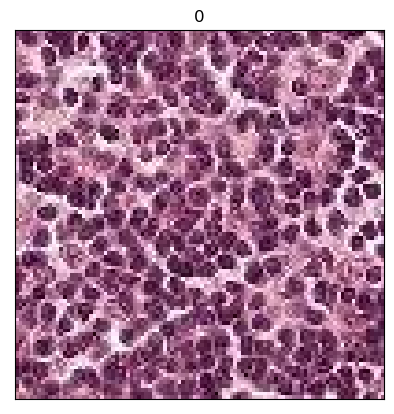

In [10]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [WINDOW_SIZE, WINDOW_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = train_labels[0]
show(img, label)

# example of a negative patch

In [11]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'D:/medical_imaging_data/patches_3/tumor_057_level2_x16800_y165600_label0.jpg', shape=(), dtype=string)
1 tf.Tensor(b'D:/medical_imaging_data/patches_3/tumor_031_level2_x52400_y150400_label1.jpg', shape=(), dtype=string)
2 tf.Tensor(b'D:/medical_imaging_data/patches_3/tumor_035_level2_x37200_y87200_label0.jpg', shape=(), dtype=string)
3 tf.Tensor(b'D:/medical_imaging_data/patches_3/tumor_031_level2_x57200_y156000_label0.jpg', shape=(), dtype=string)


In [12]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (100, 100, 3)
1 (100, 100, 3)
2 (100, 100, 3)
3 (100, 100, 3)


In [13]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(train_labels)
for label in label_ds.take(4):
  print(label.numpy())

0
1
0
0


In [14]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<ZipDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>


In [15]:
for img, label in image_label_ds.take(2):
  print(img.shape, label.numpy())

(100, 100, 3) 0
(100, 100, 3) 1


### Batch and shuffle

In [16]:
SHUFFLE_SIZE, BATCH_SIZE = 1000, 32
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 100, 100, 3) (32,)
(32, 100, 100, 3) (32,)


In [17]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

### Use in-memory caching

In [18]:
ds = image_label_ds.cache() # cache data in memory
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
time_one_epoch(ds)

................................................
Read 480 batches
6.08 Batches/s
194.71 Images/s
Total time: 78.8861300945282s


In [20]:
time_one_epoch(ds) # this will be faster because it's cached

................................................
Read 480 batches
1039.48 Batches/s
33263.29 Images/s
Total time: 0.46177029609680176s


In [21]:
# final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# make a validation dataset
path_ds = tf.data.Dataset.from_tensor_slices(val_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(val_labels)
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
val_ds = image_label_ds.cache().batch(BATCH_SIZE)

# make a test dataset
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(test_labels)
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

# Create CNN Model

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(WINDOW_SIZE, WINDOW_SIZE, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [157]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 128)      0         
 2D)                                                  

In [158]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train CNN Model

In [159]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
480/480 [==============================] - 51s 105ms/step - loss: 0.1937 - accuracy: 0.9312 - val_loss: 0.1840 - val_accuracy: 0.9518
Epoch 2/5
480/480 [==============================] - 49s 103ms/step - loss: 0.1500 - accuracy: 0.9490 - val_loss: 0.1344 - val_accuracy: 0.9536
Epoch 3/5
480/480 [==============================] - 49s 102ms/step - loss: 0.1285 - accuracy: 0.9552 - val_loss: 0.1291 - val_accuracy: 0.9580
Epoch 4/5
480/480 [==============================] - 49s 102ms/step - loss: 0.0986 - accuracy: 0.9664 - val_loss: 0.1666 - val_accuracy: 0.9484
Epoch 5/5
480/480 [==============================] - 50s 103ms/step - loss: 0.0767 - accuracy: 0.9732 - val_loss: 0.1384 - val_accuracy: 0.9580


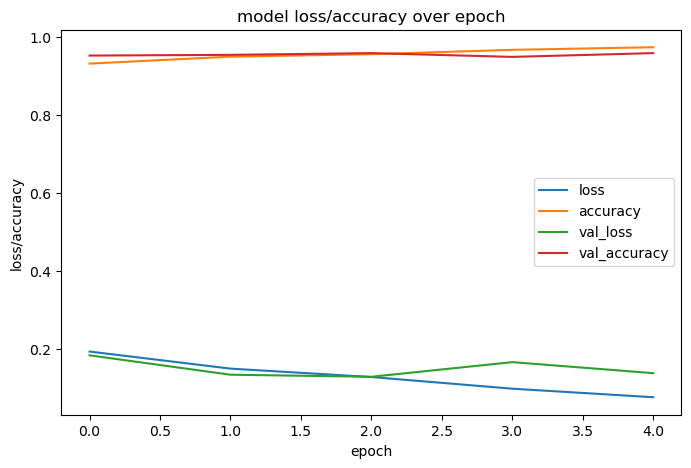

In [160]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.title('model loss/accuracy over epoch')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.show()

In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print('test acc score:', test_acc)

150/150 [==============================] - 26s 157ms/step - loss: 0.1396 - accuracy: 0.9585
test acc score: 0.9585070610046387


In [233]:
model.save('model.h5')

# Evaluation

- Classification report and auc-roc score on test set

In [74]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, RocCurveDisplay

# Calculates the confusion matrix and recover each element
def calculate_tpr_fpr(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    tpr =  tp/(tp + fn) # true positive rate, sensitivity, recall
    fpr = fp/(fp + tn) # false positive rate, fall-out
    fnr = 1 - tpr # false negative rate, miss rate
    tnr = 1 - fpr # true negative rate, specificity
    return tpr, fpr, fnr, tnr

def plot_roc_curve(y, y_pred):
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')

y_pred = model.predict(test_ds)

150/150 [==============================] - 3s 22ms/step


In [75]:
tpr, fpr, fnr, tnr = calculate_tpr_fpr(test_labels, y_pred.round())
print('True Positive Rate: %.2f%%' % (tpr * 100))
print('False Positive Rate: %.2f%%' % (fpr * 100))
print('True Negative Rate: %.2f%%' % (tnr * 100))
print('False Negative Rate: %.2f%%' % (fnr * 100))

True Positive Rate: 77.00%
False Positive Rate: 2.31%
True Negative Rate: 97.69%
False Negative Rate: 23.00%


In [76]:
print(classification_report(test_labels, y_pred.round()))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4370
           1       0.76      0.77      0.77       426

    accuracy                           0.96      4796
   macro avg       0.87      0.87      0.87      4796
weighted avg       0.96      0.96      0.96      4796



AUROC score: 0.9458


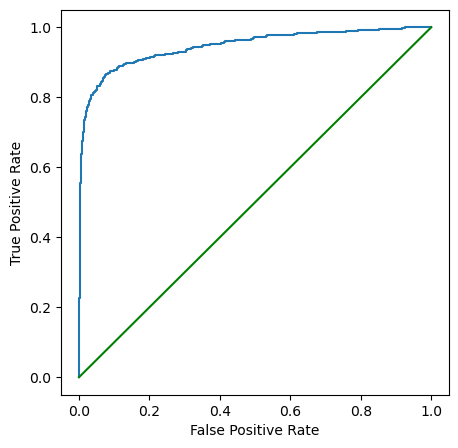

In [77]:
print("AUROC score: %.4f" %roc_auc_score(test_labels, y_pred))

plot_roc_curve(test_labels, y_pred)

## Heatmap

In [4]:
test_paths, test_mask_paths = [], []
for path in test_slides:
    test_paths.append(DATA_DIR + path)
for path in test_masks:
    test_mask_paths.append(DATA_DIR + path)

In [7]:
LEVEL = 4
WINDOW_SIZE = 100
STRIDE = 100

In [13]:
def display_slide(idx, level, width, height):
    slide = open_slide(test_paths[idx])
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=level, 
                             width=width, 
                             height=height)

    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(slide_image)

def display_mask(idx, level, width, height):
    slide = open_slide(test_paths[idx])
    mask = open_slide(test_mask_paths[idx])
    slide_image = read_slide(slide, 
                             x=0, 
                             y=0, 
                             level=level, 
                             width=width, 
                             height=height)
    mask_image = read_slide(mask, 
                             x=0, 
                             y=0, 
                             level=level, 
                             width=width, 
                             height=height)[:,:,0]
    plt.figure(figsize=(10,10), dpi=100)
    plt.imshow(slide_image)
    plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains actual cancer.
    plt.title('Actual Tumor Regions')

In [14]:
def predict_heatmap(test_idx):
    test_open_slide = open_slide(test_paths[test_idx])
    width = test_open_slide.level_dimensions[LEVEL][0]
    height = test_open_slide.level_dimensions[LEVEL][1]
    # make a blank mask
    predicted_mask = np.zeros((height, width))

    for i in range(0, test_open_slide.level_dimensions[LEVEL][0] - WINDOW_SIZE + 1, STRIDE):
        for j in range(0, test_open_slide.level_dimensions[LEVEL][1] - WINDOW_SIZE + 1, STRIDE):
            downsample_factor = int(test_open_slide.level_downsamples[LEVEL])
            x, y = i * downsample_factor, j * downsample_factor
            window_image = read_slide(test_open_slide, 
                                        x=x, 
                                        y=y, 
                                        level=LEVEL, 
                                        width=WINDOW_SIZE, 
                                        height=WINDOW_SIZE)
            # Only keep windows that contain tissue
            percent_tissue = len(find_tissue_pixels(window_image)) / float(WINDOW_SIZE * WINDOW_SIZE) * 100
            if percent_tissue > 90:
                window_image = window_image / 255.0
                window_image = tf.expand_dims(window_image, 0)
                prediction = model.predict(window_image)
                # print(prediction)
                if prediction > 0.9:
                    predicted_mask[j:j+WINDOW_SIZE, i:i+WINDOW_SIZE] = 1 

    display_slide(test_idx, LEVEL, width, height)
    plt.imshow(predicted_mask, cmap='jet', alpha=0.5)
    plt.title("Predicted Tumor Regions")

    display_mask(test_idx, LEVEL, width, height)

    return 

In [10]:
test_paths

['D:/medical_imaging_data/data/tumor_101.tif',
 'D:/medical_imaging_data/data/tumor_110.tif']

- Heatmap of cancer prediction on test slide #110

1/1 [==============================] - 0s 19ms/step


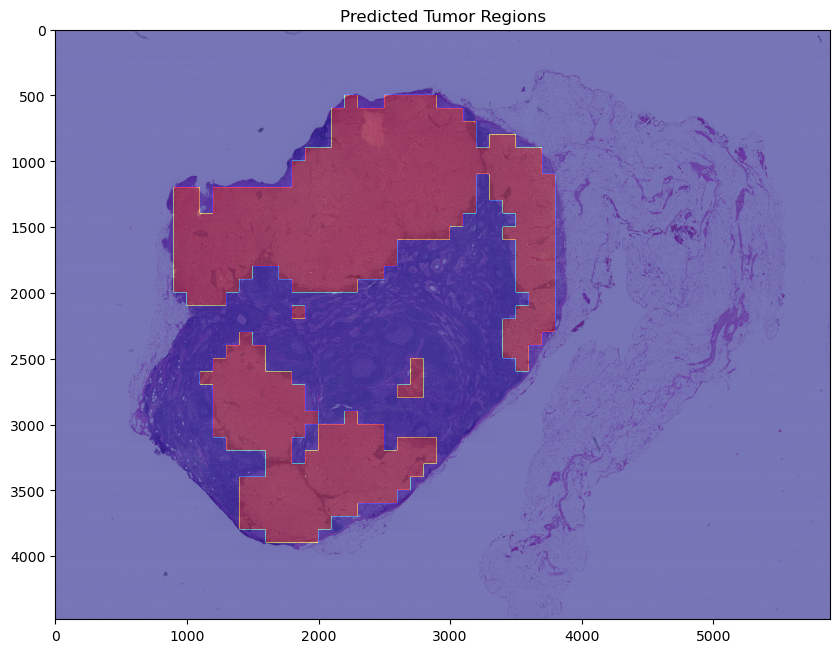

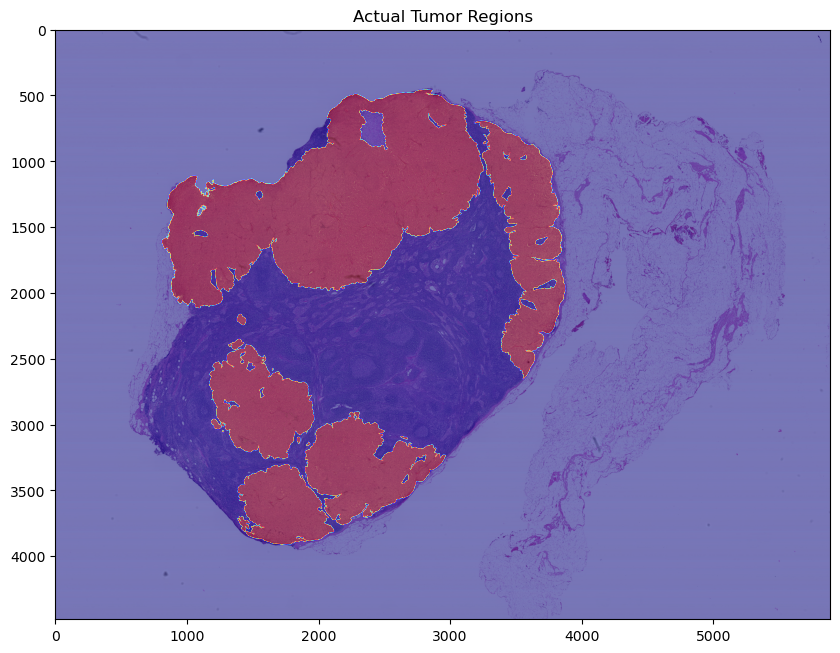

In [15]:
predict_heatmap(1)

- Heatmap of cancer prediction on test slide #101

1/1 [==============================] - 0s 17ms/step


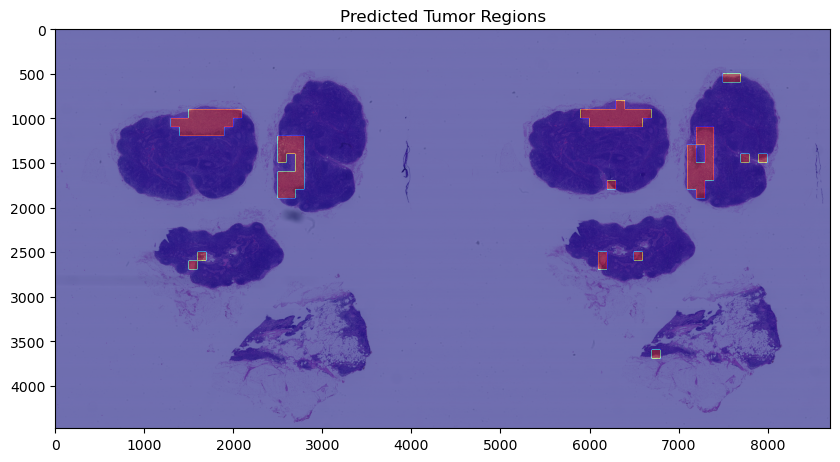

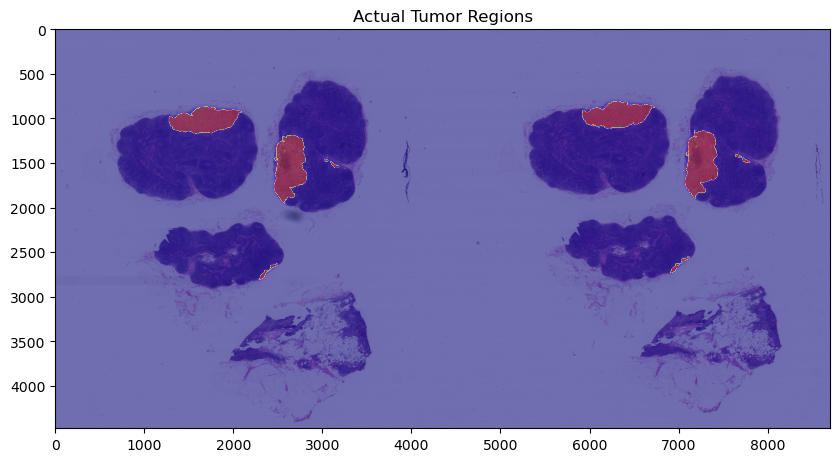

In [16]:
predict_heatmap(0)